In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
from crf.comlid_crf import *
from helper.dataset_reader import read_tsv

In [40]:
langid = LanguageIdentifier()

In [41]:
data = read_tsv('../dataset/all-merged-data-140422.tsv')

In [42]:
all_data, words, tags = data

In [43]:
# create list of tuples from all words and all tags
word_tag = list(zip(words, tags))
# print(word_tag)
# convert list to dataframe
df_wordtag = pd.DataFrame(word_tag, columns=['Token','Label'])
# df_wordtag

In [44]:
words = list(set(df_wordtag['Token'].values))
words.append("ENDPAD")
num_words = len(words)
# print(num_words)

In [45]:
tags = list(set(df_wordtag["Label"].values))
num_tags = len(tags)
# print(num_tags)

In [46]:
dt_pair = langid.data_transformer(data)
# dt_pair[0]

In [47]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

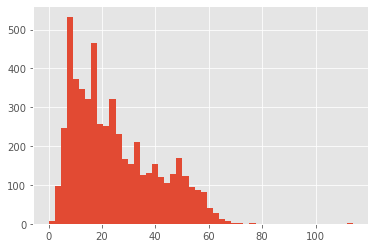

In [48]:
plt.hist([len(s) for s in dt_pair], bins=50)
plt.show()

In [49]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in dt_pair]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in dt_pair]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [50]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [51]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [52]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            1344500   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 7)             1407      
Total params: 1,466,707
Trainable params: 1,466,707
Non-trainable params: 0
_________________________________________________________________


In [53]:
import tensorflow_addons as tfa

In [54]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", ])

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

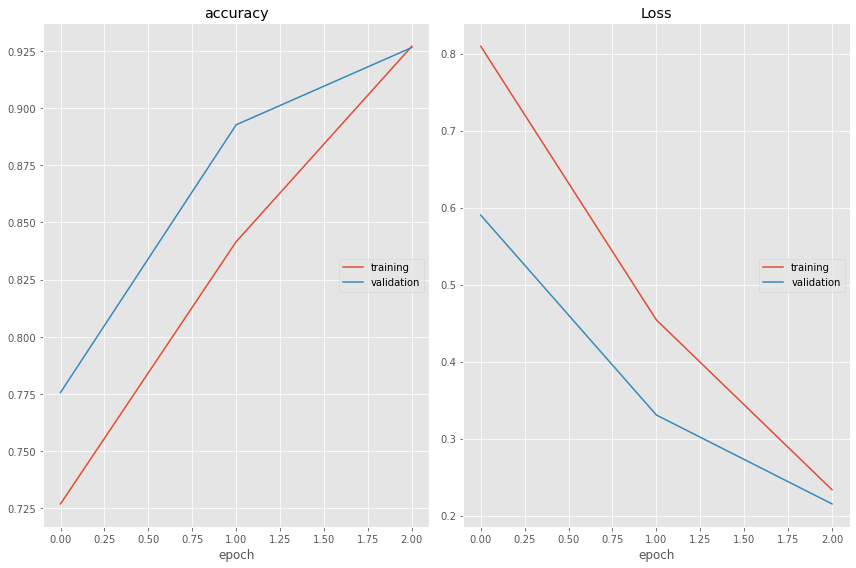

accuracy
	training         	 (min:    0.727, max:    0.927, cur:    0.927)
	validation       	 (min:    0.776, max:    0.926, cur:    0.926)
Loss
	training         	 (min:    0.233, max:    0.809, cur:    0.233)
	validation       	 (min:    0.215, max:    0.590, cur:    0.215)

Epoch 00003: val_loss improved from 0.33052 to 0.21505, saving model to model_weights.h5
CPU times: user 1min 45s, sys: 35.2 s, total: 2min 20s
Wall time: 30.7 s


In [56]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

In [57]:
model.evaluate(x_test, y_test)

56/56 [==============================] - 1s 12ms/step - loss: 0.2151 - accuracy: 0.9265


[0.21505007147789001, 0.9264682531356812]

In [58]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Word           True 	 Pred

------------------------------
@goldenhourlatteO	ID
dipostpone     MIX-ID-EN	O
dulu           ID	ID
bg             ID	ID
output         O	O
output         O	O
output         O	O
output         O	O
output         O	O
output         O	O
output         O	O
output         O	O
output       